In [2]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools

In [3]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [4]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0})
    #fitter.set_bounds("a", -np.inf, 0)
    #fitter.set_bounds("c", 0, np.inf)
    #fitter.set_p0({"a": -1})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

In [5]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [6]:
def gaussian_fits_from_data(transmissions_avg, monitors_avg, headers, default_p0=None):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0

    p0 = {"sigma": 0.3}
    if default_p0 is None:
        default_p0 = {}
    p0.update(default_p0)
    
    if not use_field_plate:
        fits = {0: {}}
        antihole_fit = get_gaussian_fit(detunings, antihole_normalized, p0=p0)
        fits[0]["ah"] = antihole_fit
        
        rf_fit = get_gaussian_fit(detunings, rf_normalized, p0=p0)
        fits[0]["rf"] = rf_fit
    else:
        fits = {1: {}, -1: {}}
        for label in [1, -1]:
            positive_stark_shift = (label * positive_field_plate) > 0
            if positive_stark_shift:
                mask = detunings > 0
            else:
                mask = detunings < 0
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_normalized[mask], p0=p0)
            fits[label]["ah"] = antihole_fit
            
            rf_fit = get_gaussian_fit(detunings[mask], rf_normalized[mask], p0=p0)
            fits[label]["rf"] = rf_fit
    return fits

In [7]:
def ah_parameters_from_data(transmissions_avg, monitors_avg, headers):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = 1 - antihole_avg[on_resonant_index] / antihole_avg[off_resonant_index]
        heights[0]["rf"] = 1 - rf_avg[on_resonant_index] / rf_avg[off_resonant_index]
        backgrounds[0]["ah"] = antihole_avg[off_resonant_index]
        backgrounds[0]["rf"] = rf_avg[off_resonant_index]
    else:
        raise NotImplementedError()
    return (heights, backgrounds)

In [8]:
def ah_parameters_from_data1(data_number):
    data, headers = get_experiment_data(data_number)
    cycles = headers["params"]["detect"]["cycles"]
    total_cycles = sum(cycles.values())
    remainder_to_label = {}
    for kk in range(total_cycles):
        last_index_of_label = 0
        for label in cycles:
            if cycles[label] > 0:
                last_index_of_label += cycles[label]
                if kk < last_index_of_label:
                    remainder_to_label[kk] = label
                    break
    data_averages = {}
    for label in cycles:
        if cycles[label] > 0:
            data_averages[label] = []
    for kk in range(len(data["transmissions_avg"])):
        remainder = kk % total_cycles
        data_averages[remainder_to_label[remainder]].append(data["transmissions_avg"][kk])

    # antihole_avg = np.average(data_averages["antihole"], axis=0)
    # rf_avg = np.average(data_averages["rf"], axis=0)
    antihole_avg = np.array(data_averages["antihole"])
    rf_avg = np.array(data_averages["rf"])
    if "chasm" in data_averages:
        chasm_avg = data_averages["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = np.average(1 - antihole_avg[:, on_resonant_index] / antihole_avg[:, off_resonant_index])
        heights[0]["rf"] = np.average(1 - rf_avg[:, on_resonant_index] / rf_avg[:, off_resonant_index])
        backgrounds[0]["ah"] = np.average(antihole_avg[off_resonant_index])
        backgrounds[0]["rf"] = np.average(rf_avg[off_resonant_index])
        # heights[0]["ah"] = 1 - np.average(antihole_avg[on_resonant_index]) / np.average(antihole_avg[off_resonant_index])
        # heights[0]["rf"] = 1 - np.average(rf_avg[on_resonant_index]) / np.average(rf_avg[off_resonant_index])
        # backgrounds[0]["ah"] = np.average(antihole_avg[off_resonant_index])
        # backgrounds[0]["rf"] = np.average(rf_avg[off_resonant_index])
    else:
        raise NotImplementedError()
    return (heights, backgrounds)

In [9]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto"):
    rf_heights = {}
    antihole_heights = {}
    rf_backgrounds = {}
    antihole_backgrounds = {}
    headers = []
    for data_number in data_numbers:
        transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number)
        if method == "auto":
            detunings_len = len(headers_single["detunings"])
            if detunings_len > 4:
                method = "fit"
            else:
                method = "ratio"
        if method == "fit":
            try:
                fits = gaussian_fits_from_data(transmissions_avg, monitors_avg, headers_single)
            except RuntimeError as e:
                print(f"Fitting error for data number #{data_number}:")
                raise e
            for label in fits:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(fits[label]["rf"].results["a"] / fits[label]["rf"].results["c"])
                antihole_heights[label].append(fits[label]["ah"].results["a"] / fits[label]["ah"].results["c"])
                rf_backgrounds[label].append(fits[label]["rf"].results["c"])
                antihole_backgrounds[label].append(fits[label]["ah"].results["c"])
        elif method == "ratio":
            heights, backgrounds = ah_parameters_from_data(transmissions_avg, monitors_avg, headers_single)
            # heights, backgrounds = ah_parameters_from_data1(data_number)
            for label in heights:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(heights[label]["rf"])
                antihole_heights[label].append(heights[label]["ah"])
                rf_backgrounds[label].append(backgrounds[label]["rf"])
                antihole_backgrounds[label].append(backgrounds[label]["ah"])
        headers.append(headers_single)
    for label in rf_heights:
        rf_heights[label] = np.array(rf_heights[label])
        antihole_heights[label] = np.array(antihole_heights[label])
        rf_backgrounds[label] = np.array(rf_backgrounds[label])
        antihole_backgrounds[label] = np.array(antihole_backgrounds[label])
    return (rf_heights, antihole_heights, rf_backgrounds, antihole_backgrounds, headers)

In [10]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

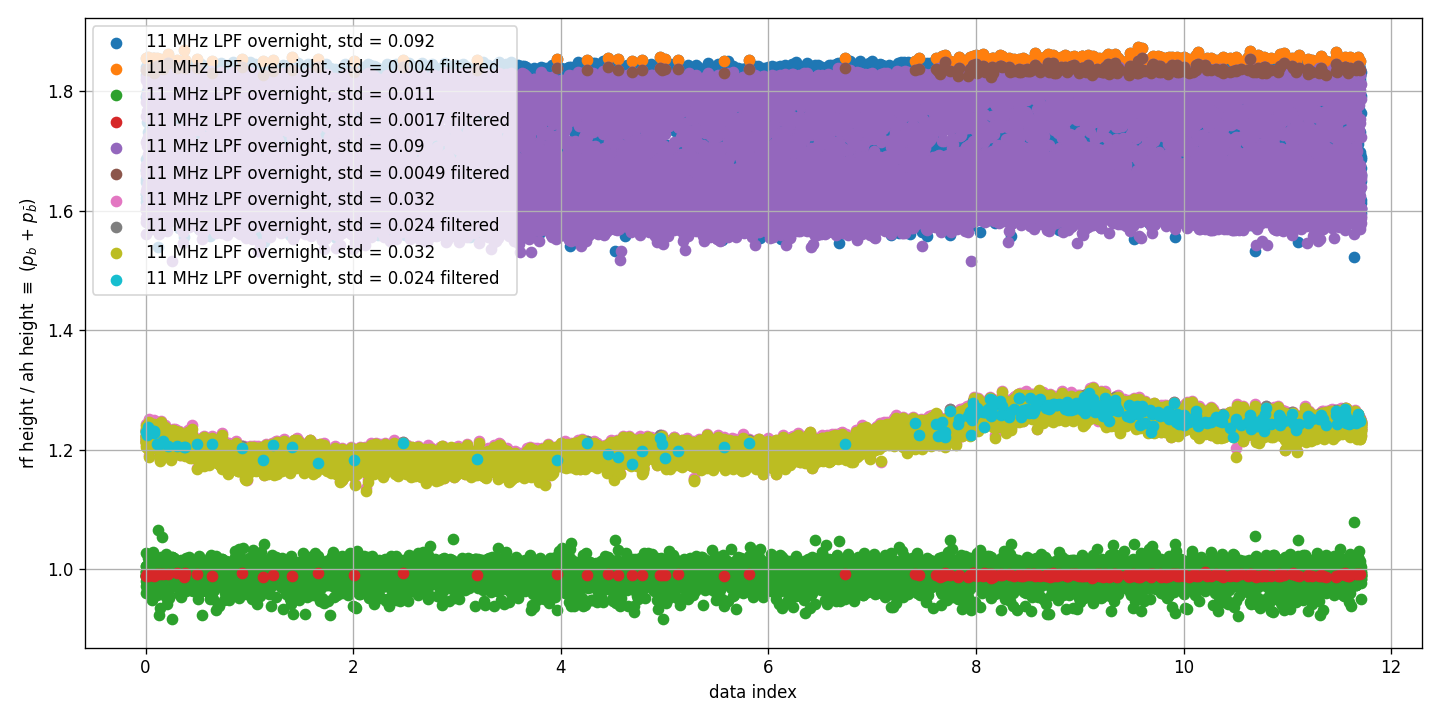

In [11]:
data = {
    # "1": (166056, 166082),
    # "2": (166083, 166101),
    # "3": (166104, 166124),
    # "4": (166125, 166136),
    # "5": (166137, 166145),
    # "6": (166146, 166161),
    # "7": (166162, 166178),
    # "8": (166179, 166201),
    # "9": (166204, 166217),
    # "10": (166221, 166258),
    # "11": (166268, 166292),
    # "12": (166293, 166307),
    # "13": (166308, 166318),
    # "14": (166325, 166403),
    # "15": (166408, 166416),
    # "16": (166423, 166432),

    # "ah 8 reps": (166696, 166747),
    # "ah 20 reps": (166748, 166801),
    # "ah 50 reps": (166802, 166824),
    # "ah 8 reps + 500 ms wait after ah": (166825, 166884),
    # "ah 8 reps + 500 ms wait after chasm": (166914, 166975),
    # "ah 8 reps again": (166976, 167020),
    # "ah 50 reps again": (167021, 167054),
    # "ah 50 reps, no inten. stab.": (167055, 167084),

    #"8 reps, 3usx32": (167366, 167637),
    #"8 reps, 50usx1": (167638, 167933),
    #"8 reps, 5usx16": (167934, 168008),
    #"8 reps, 10usx8": (168009, 168084),
    #"8 reps, 10usx4, scan": (168085, 168210),
    # "32 MHz LPF": (170900, 171429),
    # "11 MHz LPF": (171900, 172429),
    # "11 MHz LPF 2": (172430, 172440),
    "11 MHz LPF overnight": (173250, 192429),
}
def get_mask(array_to_mask, xs_mask, ys_mask, limit = 1.65):
    if label == "32 MHz LPF":
        mask = ys_mask < 1.99
        mask2 = ys_mask > 1.87
    else:
        mask = ys_mask < 5
        mask2 = ys_mask > 1.85
    mask = np.bitwise_and(mask, mask2) 
    xs2 = xs[mask]
    as2 = array_to_mask[mask]
    ax.scatter(xs2, as2, label=label + f", std = {np.std(as2):.2g} filtered")
    return xs2, as2
    
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    #xs = [header["params"]["rf"]["detuning"].to("kHz").magnitude for header in headers]
    # xs = np.array([header["data_info"]["data_number"] for header in headers])
    xs = np.array([header["data_info"]["save_epoch_time"] for header in headers])
    xs = (xs - np.min(xs))/3600
        
    # ys = rf_bgs[0] / ah_bgs[0]
    # ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    # ys = rf_bgs[0] * (1 - rf_heights[0]) / (ah_bgs[0] * (1 - ah_heights[0]))
    # ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")

    ys = np.abs(ah_heights[0]) * 14
    ys_to_mask = ys
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
    ys = np.array(rf_heights[0] / (ah_heights[0]))
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
    ys = np.abs(rf_heights[0]) * 14
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
    ys = ah_bgs[0]
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
    ys = rf_bgs[0]
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
#ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_xlabel("data index")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

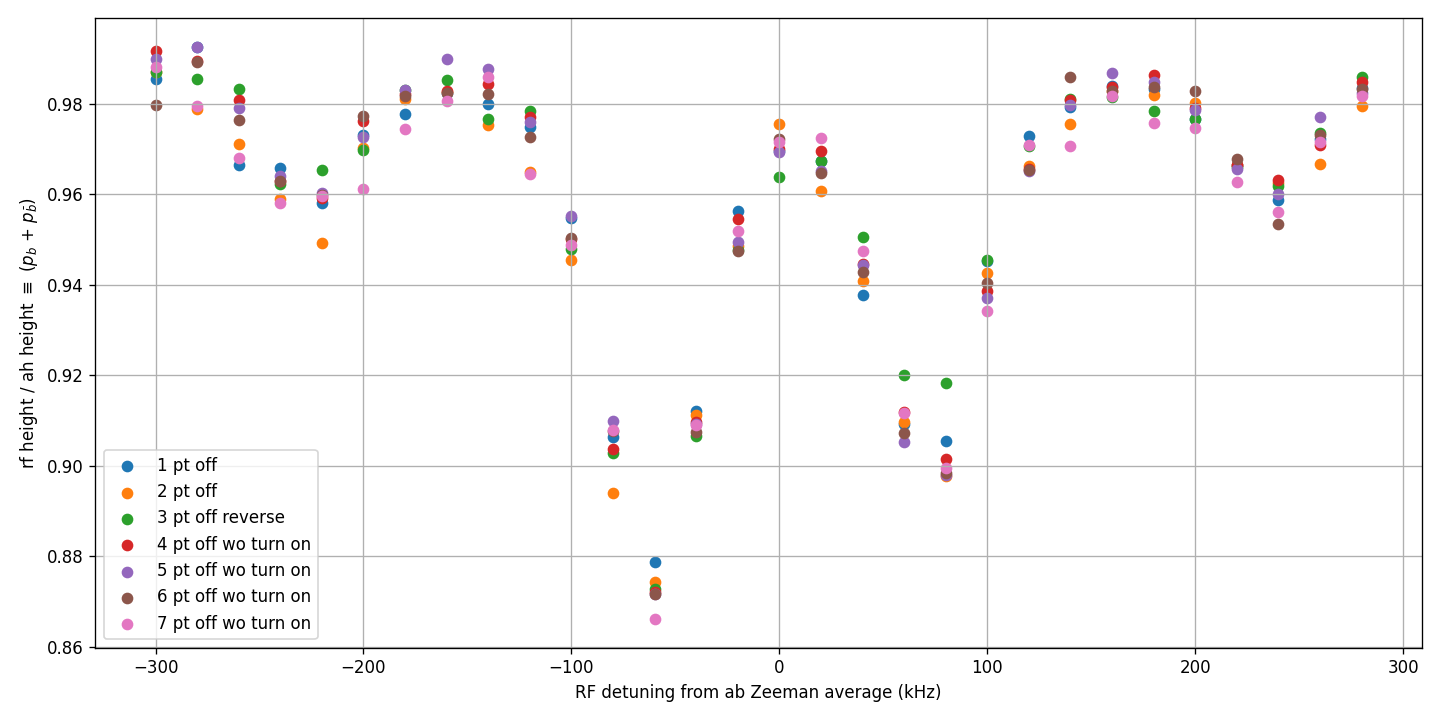

In [274]:
data = {
    #"spec": (166565, 166604),
    #"spec1": (166605, 166607),
    # "after thermalization": (167284, 167323),
    # "reverse freq order": (167324, 167363),

    #--
    # "1 pt on": (195130, 195159),
    # "2 pt on": (195160, 195189),
    "1 pt off": (195190, 195219),
    "2 pt off": (195220, 195249),
    # "3 pt on": (195250, 195279),
    # "4 pt on": (195280, 195309),
    "3 pt off reverse": (195310, 195339),
    "4 pt off wo turn on": (195340, 195369),
    "5 pt off wo turn on": (195370, 195399),
    "6 pt off wo turn on": (195400, 195429),
    "7 pt off wo turn on": (195430, 195459),
    # "8 pt off wo turn on": (195460, 195489),
    # "9 pt off wo turn on": (195490, 195519),


}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.scatter(xs, ys, label=label)
    # ys = ah_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = ah_bgs[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_bgs[0]
    # ax.scatter(xs, ys, label=label)
    
ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

/home/icarus/.venv/vlab/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


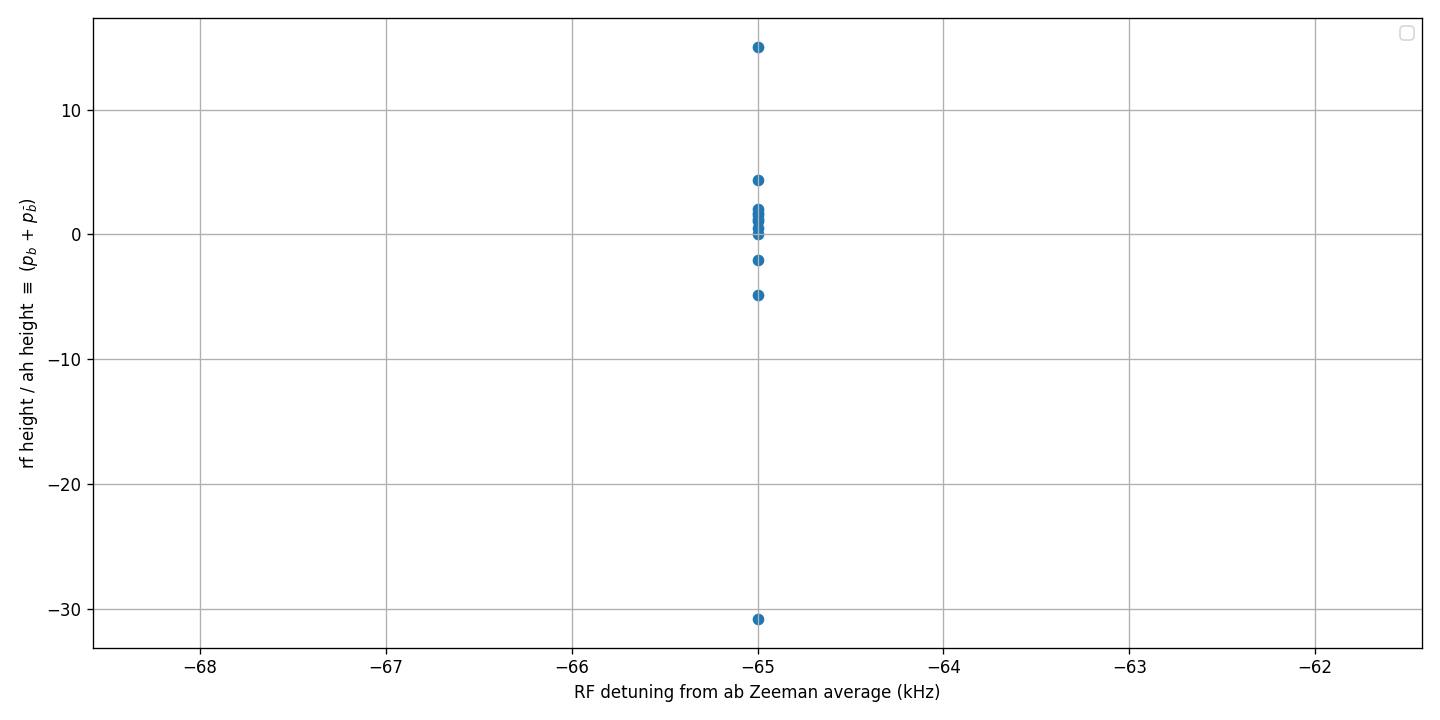

In [280]:
data = {
    "":(195599, 195610)
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["probe_detunings"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.scatter(xs, ys, label=label)
    # ys = ah_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = ah_bgs[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_bgs[0]
    # ax.scatter(xs, ys, label=label)
    
ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

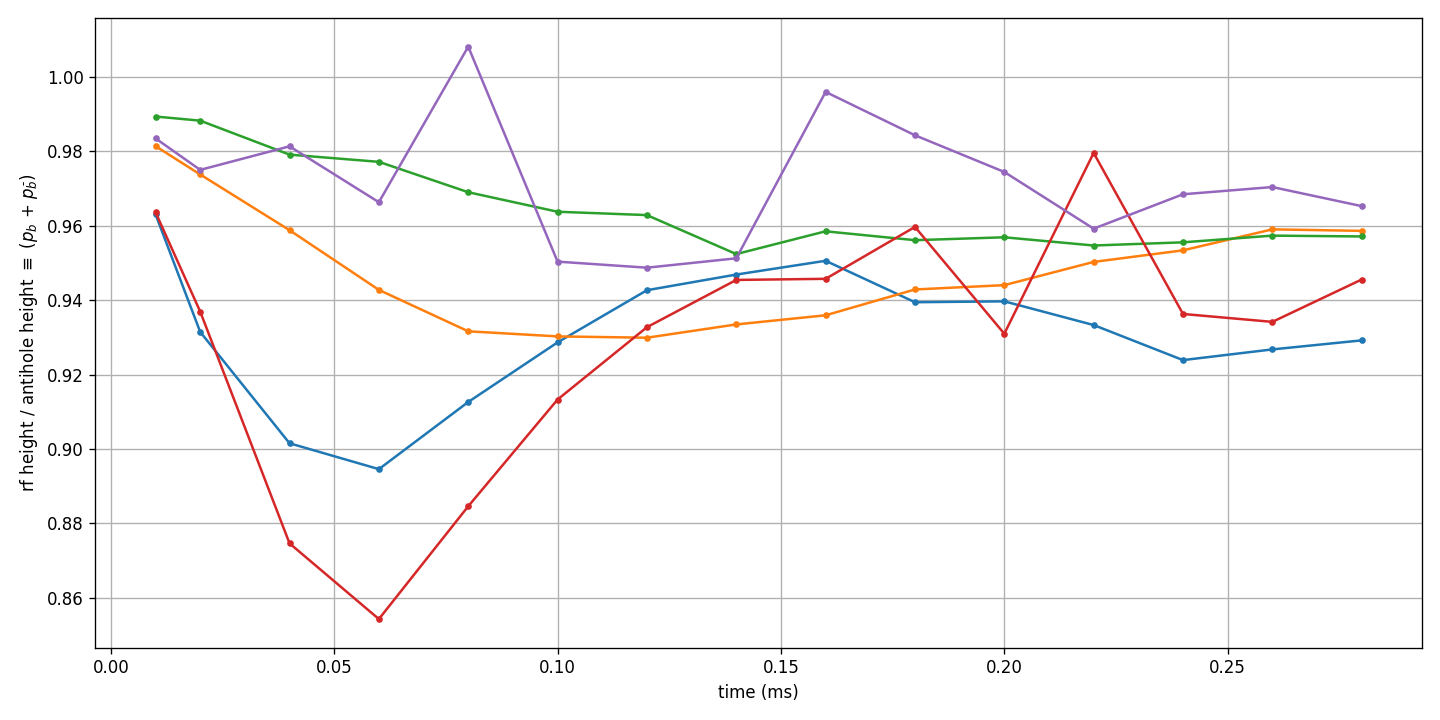

In [279]:
data = {
    # "-70 kHz, 4200": (166505, 166524),
    # "70 kHz, 4200": (166525, 166544),
    # "70 kHz, 4200, 4x": (166545, 166564),
    # "0 amplitude 1": (167183, 167202),
    # "0 amplitude 2": (167203, 167222),
    # "-70 kHz, 4200, 4, 4": (167223, 167242),
    # "-70 kHz, 4200, 20, 1": (167243, 167262),
    # "-70 kHz, 4200, 20, 4": (167263, 167282),

    #---

    "pt off 4200": (195524, 195538),
    "kept pt off 2100": (195539, 195553),
    "kept pt off 1050": (195554, 195568),
    "PT ON 4200": (195569, 195583),
    "pt on 2100": (195584, 195598),





}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["duration"].to("ms").magnitude for header in headers]
    #xs = [header["data_info"]["data_number"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.plot(xs, ys, '.-', label=label)
    # ys = ah_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = ah_bgs[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_bgs[0]
    # ax.scatter(xs, ys, label=label)

ax.set_xlabel("time (ms)")
#ax.set_xlabel("data index")
ax.set_ylabel("rf height / antihole height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
# ax.legend()
ax.grid()
plt.tight_layout()
plt.show()
fig.canvas.draw()

In [14]:
data, headers = get_experiment_data(169641)

In [15]:
detunings_MHz = headers["detunings"].to("MHz").magnitude
transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])

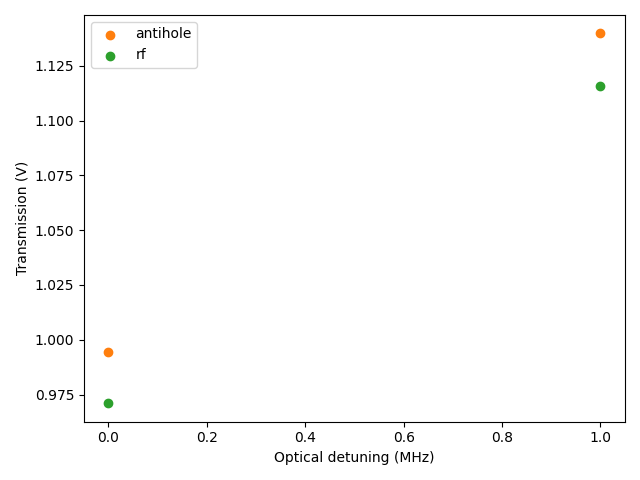

In [16]:
plt_monitor = False
use_positive = None

antihole_avg = transmissions_avg["antihole"]
rf_avg = transmissions_avg["rf"]
if "chasm" in transmissions_avg:
    chasm_avg = transmissions_avg["chasm"]
    antihole_normalized = antihole_avg / chasm_avg
    rf_normalized = rf_avg / chasm_avg
else:
    chasm_avg = None
    antihole_normalized = antihole_avg
    rf_normalized = rf_avg

if use_positive == True:
    mask = detunings_MHz > 0
elif use_positive == False:
    mask = detunings_MHz < 0
else:
    mask = detunings_MHz < 1e13

fig, ax = plt.subplots()
#ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
ax.scatter(detunings_MHz[mask], antihole_normalized, label="antihole", color="C1")
ax.scatter(detunings_MHz[mask], rf_normalized, label="rf", color="C2")

xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
#antihole_fit = get_gaussian_fit(detunings_MHz[mask], antihole_normalized, p0={"f_0": np.average(detunings_MHz[mask]) + 0.001, "sigma": 0.005, "a": 0.01, "c": 0.011})
#ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "hole fit", color="C1")
#rf_fit = get_gaussian_fit(detunings_MHz[mask], rf_normalized, p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
#ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.legend()
plt.tight_layout()
plt.show()

#print(antihole_fit.all_results_str())
print()
#print(rf_fit.all_results_str())

0.1342515292702997 0.13663296442487505
0.11994857630657918 0.12846181099263132
0.10661079743019874 0.12267009301161869
0.09346732048194639 0.11664213631970732
0.07723708498225068 0.10896275757192708
0.061737019217272704 0.10330911303105528
0.04728419248732152 0.09520452269159063
0.035123422107283364 0.08367565018938616


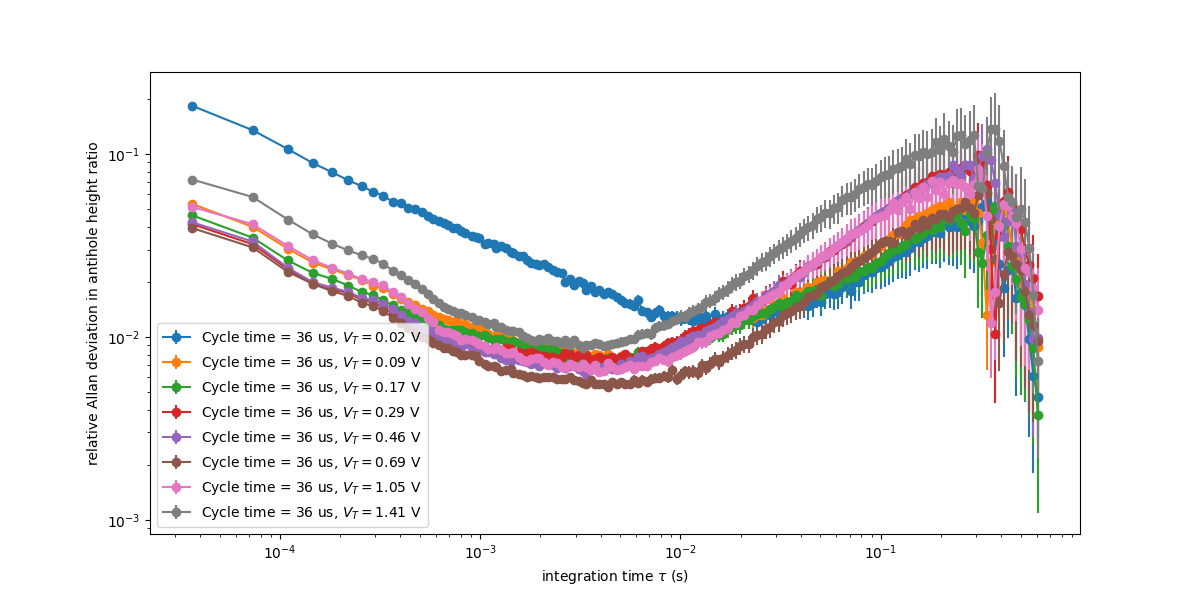

In [17]:
labels = [170298, 170299, 170305, 170300, 170304, 170301, 170303, 170302]
labels = dict([(kk, kk) for kk in labels])

# labels = [170306, 170323, 170325, 170318, 170328, 170327, 170313, 170314]
# labels = dict([(kk, kk) for kk in labels])

fig, ax = plt.subplots(figsize=(12, 6))
for kk, label in enumerate(labels):
    data, headers = get_experiment_data(labels[label])  # 169455 - amp 210, 169456 - amp 160
    cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5).to("s").magnitude) + 24e-6
    cycles = headers["params"]["detect"]["cycles"]["antihole"]
    
    times = np.arange(cycles) * cycle_time
    ah_ratios = data["transmissions_avg"][:cycles,0] / data["transmissions_avg"][:cycles,1]
    rf_ratios = data["transmissions_avg"][cycles:cycles*2,0] / data["transmissions_avg"][cycles:cycles*2,1]
    ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
    print(1- np.average(rf_ratios), 1- np.average(ah_ratios))
    
    fitter = Fitter(lambda x, a, b: a * x + b)
    fitter.set_data(times, ratios)
    fitter.fit()
    ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, ah_ratios)
    fitter.fit()
    ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, rf_ratios)
    fitter.fit()
    rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]
    plot_variable = np.copy(ratios_no_bg)
    
    plot_variable /= np.average(plot_variable)
    taus = np.logspace(0, np.log10(len(plot_variable) // 3), 200)
    real_taus, allan, allan_err, _ = allantools.adev(plot_variable, data_type="freq", taus=taus)
    #allan *= np.sqrt(np.average(data["transmissions_avg"]))
    #allan_err *= np.sqrt(np.average(data["transmissions_avg"]))
    real_taus *= cycle_time
    #ax.plot(real_taus, allan[0] / np.sqrt(real_taus / real_taus[0]), color=f"C{kk}", ls="--")
    ax.errorbar(real_taus, allan, allan_err, fmt="o", ls="-", label=f"Cycle time = {cycle_time*1e6:.0f} us" + ", $V_T=" + f"{np.average(data["transmissions_avg"]):.2f}$ V", color=f"C{kk}")
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("integration time $\\tau$ (s)")
ax.set_ylabel("relative Allan deviation in antihole height ratio")
ax.legend()
plt.show()

-0.002100124432288686 -0.0021735106776623603
1.6899026788984026
--
0.11252502709317214 0.11208668138205624
1.5327439035688126
--
0.10088634097195492 0.1020595992858313
1.4210084479195728
--
0.10873918333367438 0.10789638700193893
1.3628977257864812
--
0.1111205015656449 0.11022493056167482
1.3656863294328963
--
0.08994635989523292 0.08864488123705017
1.4271865953717913
--
-0.023050058507226856 -0.022747515054164946
1.475594468797956
--
0.09368500578472239 0.09261235621914721
1.44855623790196
--
0.09187850275351161 0.09111770862526025
1.4559175137111118
--
0.09340722177349192 0.09294690112431825
0.7309970229012626
--
0.09212105925045022 0.08850997415493556
0.7613485555078756
--
0.0725704122176668 0.07070953705994765
0.5739517021179199
--
0.08707383216835263 0.08656475871035485
0.555399728502546
--
0.08895960506763745 0.08800411856293222
0.5449397877284459
--
0.08815101043594209 0.08722605247306747
1.109868278503418
--


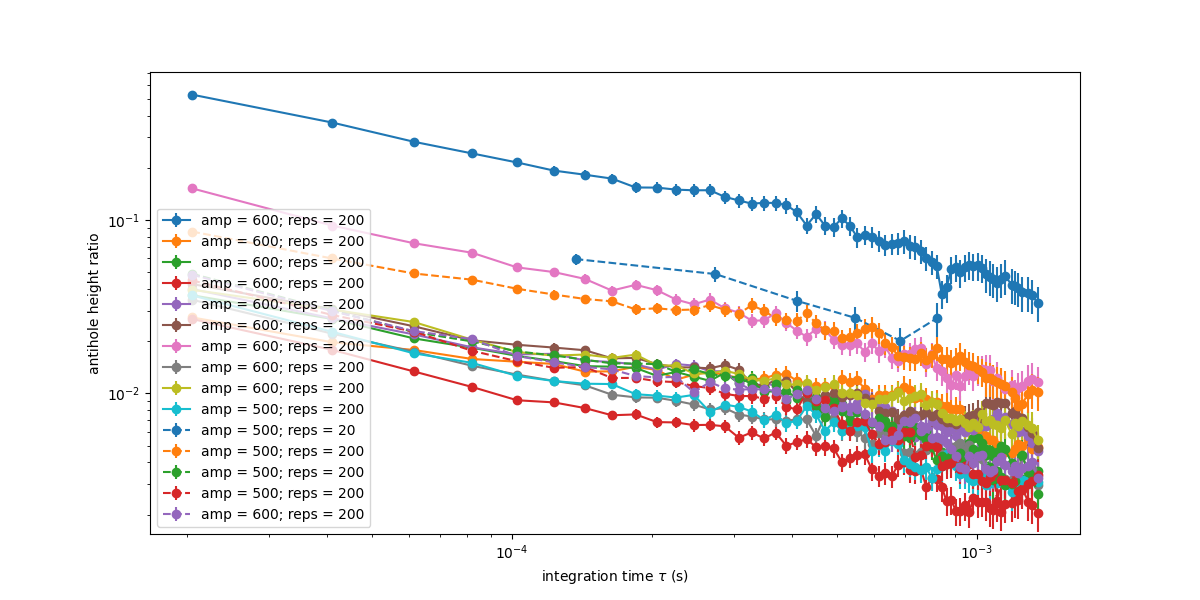

In [258]:
# data, headers = get_experiment_data(170296)
data, headers = get_experiment_data(192435) # 4 K, 380 amplitude
# data, headers = get_experiment_data(192436) 
data, headers = get_experiment_data(192438) # 7 K, 380 amplitude
data, headers = get_experiment_data(192439) # 4 K, 300 amplitude
# # data, headers = get_experiment_data(192440) # 4 K, 300 amplitude
# data, headers = get_experiment_data(192443) # 4 K, 200 amplitude 1000000 detects
# data, headers = get_experiment_data(192444) # 4 K, 200 amplitude 100000 detects
# data, headers = get_experiment_data(192445) # 4 K, 250 amplitude 100000 detects
# data, headers = get_experiment_data(192446) # 4 K, 180 amplitude 100000 detects
# data, headers = get_experiment_data(192447) # 4 K, 220 amplitude 100000 detects
data, headers = get_experiment_data(192448)
data, headers = get_experiment_data(192449)
data, headers = get_experiment_data(192450)
data, headers = get_experiment_data(192451)
data, headers = get_experiment_data(192452)
# data, headers = get_experiment_data(192461)
#192451 - no vibration
#192457 2.8 Hz hammer
#192458 3 Hz hammer
#192459 2 Hz hammer
#192461 - baseline #1
#192462 - baseline #2
#192463 - baseline #3

lines = ["-", "--"]
data_groups = {
    # "baseline": [192461, 192462, 192463, 192464, 192465],
    # "angles removed from optics platform": [192466, 192467, 192468, 192469, 192470, 192471, 192472],
    # "more things loosened up - transmisison pd platform, fridge-platform beam": [192475, 192476, 192477, 192478, 192479, 192480, 192481, 192482, 192483],
    # "changing beam size 1": [192484], # 6 turns CW
    # "changing beam size 2": [192485], # 0 turns CW ao amplitude 220
    # "changing beam size 3, amp 200": [192487], # 3 turns CW, ao amplitude 200
    # "changing beam size 3, amp 220": [192486], # 3 turns CW, ao amplitude 220
    # "changing beam size 3, amp 230": [192489], # 3 turns CW, ao amplitude 230
    # "changing beam size 3, amp 240": [192488], # 3 turns CW, ao amplitude 240
    # "changing beam size 3, amp 250": [192490], # 3 turns CW, ao amplitude 250
    # "changing beam size 3, amp 260": [192491], # 3 turns CW, ao amplitude 260
    # "changing beam size 3, amp 270": [192492], # 3 turns CW, ao amplitude 270
    # "changing beam size 3, amp 300": [192493], # 3 turns CW, ao amplitude 300
    # "changing beam size 3, amp 320": [192494], # 3 turns CW, ao amplitude 320
    # "changing beam size 3, amp 340": [192495], # 3 turns CW, ao amplitude 320
    # "changing beam size 3, amp 400": [192496], # 3 turns CW, ao amplitude 320
    # "changing beam size 3, amp 500": [192497, 192502, 192503, 192504],
    # "changing beam size 3, amp 600": [192498, 192499, 192500, 192501],
    # "changing beam size 3, amp 650": [192510, 192511, 192512, 192513],
    # "changing beam size 3, amp 700": [192506, 192507, 192508, 192509],
    # "amp 200": [192514, 192515, 192516, 192517, 192518],
    # "amp 300": [192519, 192520, 192521, 192522, 192523],
    # "amp 400": [192524, 192525, 192526, 192527, 192528],
    # "amp 500": [192529, 192530, 192531, 192532, 192533],
    # "amp 600": [192534, 192535, 192536, 192537, 192538],
    # # "amp 700": [192539, 192540, 192541, 192542, 192543],
    # # "amp 800": [192544, 192545, 192546, 192547, 192548],
    # "0": (193225, 193249),
    # "1": (193225, 193274),
    # "2": (193225, 193299),
    # "3": (193225, 193324),
    # "4": (193225, 193349),
    # "5": (193225, 193374),
    # "6": (193225, 193399),
    # "7": (193225, 193424),
    # "8": (193225, 193449),
    # "9": (193225, 193474),
    # "10": (193225, 193499),
    # "11": (193225, 193524),
    # "12": (193225, 193549),
    # "13": (193225, 193574),
    # "14": (193225, 193599),
    # "15": (193225, 193624),
    # "16": (193225, 193649),
    # "17": (193225, 193674),
    # "18": (193225, 193699),
    # "19": (193225, 193724),
    # "20": (193225, 193749),
    # "21": (193225, 193774),
    # "22": (193225, 193799),
    # "23": (193225, 193824),
    # "24": (193225, 193849),
    # "25": (193225, 193874),
    # "26": (193225, 193899),
    # "27": (193225, 193924),
    # "28": (193225, 193949),
    # "29": (193225, 193974),
    # "30": (193225, 193999),
    # "31": (193225, 194024),
    # "32": (193225, 194049),
    # "33": (193225, 194074),
    # "34": (193225, 194099),
    # "35": (193225, 194124),
    # "1": (194127, 194146),
    # "2": (194147, 194166),
    # "3": (194167, 194186),
    # "4": (194187, 194206),
    # # "5": (194207, 194226),
    # # "6": (194227, 194246),
    # # "7": (194247, 194266),
    # # "8": (194267, 194286),
    # "5": (194287, 194386),
    # # "6": (194287, 194291),
    # # "7": (194382, 194386),
    # # "8": (194330, 194334),
    # "9": (194487, 194586),
    # "10": (194587, 194686),
    # "11": (194687, 194786),
    # "12": (194817, 194826),
    "13": (194917, 194926), # pd oversaturated
    "14": (194927, 194936), 
    "19": (194990, 194999), # long eom
    "20": (195000, 195009), # pt off
    "21": (195010, 195019), # detunings [0, 2]
    "22": (195020, 195029), # ah repeats 20
    "23": (195030, 195039), # no antihole
    "24": (195040, 195049), # pt off
    "25": (195050, 195059), # pt on
    "26": (195060, 195069), # pt off to 500 amp
    "27": (195070, 195079), #pt off 50:10 on off time
    "28": (195090, 195099), # pt on bb
    "29": (195100, 195109), # pt off bb
    "30": (195110, 195119), # pump off
    "31": (195120, 195129), # 600 amp

    












}#[192451, 192457, 192458, 192459]
fig, ax = plt.subplots(figsize=(12, 6))
for ll, (label, data_group) in enumerate(data_groups.items()):
    allans = []
    allan_errs = []
    if isinstance(data_group,(list,np.ndarray)):
        pass
    elif isinstance(data_group, (tuple)):
        data_group = range(data_group[0], data_group[1]+1)
    for kk in data_group:
        data, headers = get_experiment_data(kk)
        transmissions_avg = data["transmissions_avg"]
        fitter = Fitter(lambda x, a, b: a * x + b)
        
        cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5 + headers["params"]["detect"]["delay"]).to("s").magnitude) + 4e-6
        # print(headers["params"]["detect"]["on_time"])
        cycles = headers["params"]["detect"]["cycles"]["antihole"]
        
        factor = 1
        times = np.arange(cycles*factor) * cycle_time
        ah_ratios = transmissions_avg[:cycles*factor,0] / transmissions_avg[:cycles*factor,1]
        rf_ratios = transmissions_avg[cycles*factor:cycles*factor*2,0] / transmissions_avg[cycles*factor:cycles*factor*2,1]
        ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
        fitter.set_data(times, ratios)
        fitter.fit()
        
        # fig, ax = plt.subplots(figsize=(12, 6))
        #ax.plot(times, ratios)
        #ax.plot(times, fitter.fitted_value(times))
        ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, ah_ratios)
        fitter.fit()
        ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, transmissions_avg[:cycles*factor,0])
        fitter.fit()
        ah_on_res_no_bg = transmissions_avg[:cycles*factor,0] - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, transmissions_avg[:cycles*factor,1])
        fitter.fit()
        ah_off_res_no_bg = transmissions_avg[:cycles*factor,1] - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, rf_ratios)
        fitter.fit()
        rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]
        
        plot_variable = np.copy(ratios_no_bg)
        #ax.plot(times, plot_variable)
        #ax.plot(times, ah_ratios_no_bg)
        #ax.plot(times, rf_ratios_no_bg)
        # ax.plot(times, ah_on_res_no_bg)
        # ax.plot(times, ah_off_res_no_bg)
        # ax.set_xlabel("time (s)")
        # ax.set_ylabel("transmission (V)")
        
        plot_variable /= np.average(plot_variable)
        # print(np.std(plot_variable))
        taus = np.logspace(0, np.log10(len(plot_variable) // 3), 200)
        real_taus, allan, allan_err, _ = allantools.adev(plot_variable, data_type="freq", taus=taus)
        real_taus *= cycle_time
        allans.append(allan)
        allan_errs.append(allan_err)
        # print(kk)
    print(1- np.average(ah_ratios), 1- np.average(rf_ratios))
    print(np.average(transmissions_avg))
        
    allan2 = np.average(allans, axis=0)
    allan_err2 = np.average(allan_errs, axis=0)/np.sqrt(len(data_group))
    label = f"amp = {headers["params"]["detect"]["ao_amplitude"]}; reps = {headers["params"]["detect"]["cycles"]["antihole"]}"#; on time = {headers["params"]["detect"]["on_time"]}; off time = {headers["params"]["detect"]["off_time"]}"
    print("--")
    ax.errorbar(real_taus, allan2, allan_err2, fmt="o", ls=lines[ll//10], label=label)
            
    # ax.plot(real_taus, allan2[0] / np.sqrt(real_taus / real_taus[0]), ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("integration time $\\tau$ (s)")
    ax.set_ylabel("antihole height ratio")
plt.legend()
plt.show()

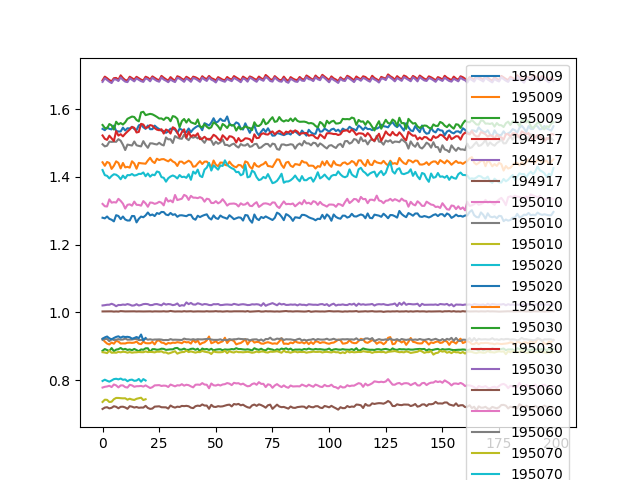

In [244]:
data_numbers = [195009, 194917, 195010, 195020, 195030, 195060, 195070]


fig, ax = plt.subplots()
for data_number in data_numbers:
    data, headers = get_experiment_data(data_number)
    
    transmissions_avg = data["transmissions_avg"]
    fitter = Fitter(lambda x, a, b: a * x + b)
    
    cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5 + headers["params"]["detect"]["delay"]).to("s").magnitude) + 4e-6
    # print(headers["params"]["detect"]["on_time"])
    cycles = headers["params"]["detect"]["cycles"]["antihole"]
    
    factor = 1
    times = np.arange(cycles*factor) * cycle_time
    ah_ratios = transmissions_avg[:cycles*factor,0] / transmissions_avg[:cycles*factor,1]
    rf_ratios = transmissions_avg[cycles*factor:cycles*factor*2,0] / transmissions_avg[cycles*factor:cycles*factor*2,1]
    ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
    fitter.set_data(times, ratios)
    fitter.fit()
    
    # fig, ax = plt.subplots(figsize=(12, 6))
    #ax.plot(times, ratios)
    #ax.plot(times, fitter.fitted_value(times))
    ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, ah_ratios)
    fitter.fit()
    ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, transmissions_avg[:cycles*factor,0])
    fitter.fit()
    ah_on_res_no_bg = transmissions_avg[:cycles*factor,0] - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, transmissions_avg[:cycles*factor,1])
    fitter.fit()
    ah_off_res_no_bg = transmissions_avg[:cycles*factor,1] - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, rf_ratios)
    fitter.fit()
    rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]
    
    ax.plot(transmissions_avg[:cycles*factor,0], label=str(data_number))
    ax.plot(transmissions_avg[:cycles*factor,1], label=str(data_number))
    ax.plot(ah_ratios_no_bg, label=str(data_number))
plt.legend()
plt.show()

In [281]:
data, headers = get_experiment_data(195599)

In [283]:
headers["params"]["rf"]

{'pump_amplitude': 4200,
 'probe_amplitude': 125,
 'pump_detunings': array([-65]) <Unit('kilohertz')>,
 'probe_detunings': array([-65]) <Unit('kilohertz')>,
 'pump_time': 0.06 <Unit('millisecond')>,
 'probe_time': 0.12 <Unit('millisecond')>,
 'delay_time': 0.1 <Unit('millisecond')>,
 'probe_phase': 0,
 'name': 'rf_coil',
 'transition': 'ab',
 'offset': 30 <Unit('kilohertz')>,
 'probe_detuning': -68.0 <Unit('kilohertz')>}